# ERC-4626: vault report for blog posts

- This is the same as [ERC-4626 best vaults](./erc4626-best-vaults.html) notebook, but tailored for the blog post output
- The output is condensed with less charts, lists and data points
- Tables are outputted as Markdown for copy-paste and the rendering is left to the blog engine
- Vaults are ranked by 1M returns unless noted otherwise

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [1]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.research.notebook import set_large_plotly_chart_font

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://stackoverflow.com/a/74609837/315168
assert hasattr(pio, "kaleido"), "Kaleido rendering backend missing. Run 'pip install kaleido' needed for this notebook"
pio.kaleido.scope.default_format = image_format

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

# Set all Plotly charts to use large font sizes for better readability,
# for sharing on mobile
set_large_plotly_chart_font(line_width=5, legend_font_size=16)
pio.templates.default = "custom"

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_73924/1747694510.py:22: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_format is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_format instead.




## Read previously scanned vault price data

- Read the Parquet file produced earlier with price scan 

In [2]:
from pathlib import Path
from eth_defi.vault.vaultdb import VaultDatabase, read_default_vault_prices
from eth_defi.research.vault_metrics import cross_check_data

output_folder = Path("~/.tradingstrategy/vaults").expanduser()
parquet_file = output_folder / "cleaned-vault-prices-1h.parquet"
assert parquet_file.exists(), "Run the vault scanner script first"

vault_db = VaultDatabase.read()
prices_df = read_default_vault_prices()

chains = prices_df["chain"].unique()

print(f"The report data is dated {prices_df.index.min()} - {prices_df.index.max()}")
print(f"We have {len(prices_df):,} price rows and {len(vault_db)} vault metadata entries for {len(chains)} chains")

# sample_vault = next(iter(vault_db.values()))
# print("We have vault metadata keys: ", ", ".join(c for c in sample_vault.keys()))
# display(pd.Series(sample_vault))

print("We have prices DataFrame columns: ", ", ".join(c for c in prices_df.columns))
print("DataFrame sample:")
display(prices_df.head(3))

errors = cross_check_data(
    vault_db,
    prices_df,
)
assert errors == 0, f"Data Cross-check found: {errors} errors"



The report data is dated 2022-03-22 02:38:06 - 2025-12-22 13:55:27
We have 5,940,085 price rows and 26382 vault metadata entries for 21 chains
We have prices DataFrame columns:  id, chain, address, block_number, share_price, total_assets, total_supply, performance_fee, management_fee, errors, name, event_count, protocol, raw_share_price, returns_1h, avg_assets_by_vault, dynamic_tvl_threshold, tvl_filtering_mask
DataFrame sample:


id  chain  \
timestamp                                                                  
2025-03-20 14:07:11  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-20 15:07:23  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-20 16:07:23  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   

                                                        address  block_number  \
timestamp                                                                       
2025-03-20 14:07:11  0x00000000efe883b3304aff71eacf72dbc3e1b577      22088567   
2025-03-20 15:07:23  0x00000000efe883b3304aff71eacf72dbc3e1b577      22088867   
2025-03-20 16:07:23  0x00000000efe883b3304aff71eacf72dbc3e1b577      22089167   

                     share_price  total_assets  total_supply  performance_fee  \
timestamp                                                                       
2025-03-20 14:07:11         1.00    907,086.93    907,086.93              NaN   
2025-03-20 15:07:23         1.00  2,889,651.76  2,889,651.76              NaN   
2025-03-20 16:07:23         1.00  2,990,157.03  2,990,157.03              NaN   

                     management_fee errors                     name  \
timestamp                                                             
2025-03-20 14:07:11             NaN         Resupply Insurance Pool   
2025-03-20 15:07:23             NaN         Resupply Insurance Pool   
2025-03-20 16:07:23             NaN         Resupply Insurance Pool   

                     event_count                       protocol  \
timestamp                                                         
2025-03-20 14:07:11         9825  <protocol not yet identified>   
2025-03-20 15:07:23         9825  <protocol not yet identified>   
2025-03-20 16:07:23         9825  <protocol not yet identified>   

                     raw_share_price  returns_1h  avg_assets_by_vault  \
timestamp                                                               
2025-03-20 14:07:11             1.00         NaN        28,082,212.42   
2025-03-20 15:07:23             1.00        0.00        28,082,212.42   
2025-03-20 16:07:23             1.00        0.00        28,082,212.42   

                     dynamic_tvl_threshold  tvl_filtering_mask  
timestamp                                                       
2025-03-20 14:07:11             561,644.25               False  
2025-03-20 15:07:23             561,644.25               False  
2025-03-20 16:07:23             561,644.25               False

## Filter down to USD-based vaults

- In this notebooks, we focus on stablecoin yield
- Do not consider WETH, other native token vaults, as their returns calculation 
  would need to match the appreciation of underlying assets
- [is_stablecoin_like](https://web3-ethereum-defi.readthedocs.io/api/core/_autosummary/eth_defi.token.is_stablecoin_like.html?highlight=is_stablecoin_like#eth_defi.token.is_stablecoin_like) supports GHO, crvUSD and other DeFi/algorithmic stablecoins
- Note that this picks up very few EUR and other fiat-nominated vaults


In [ ]:
from eth_defi.token import is_stablecoin_like

usd_vaults = [v for v in vault_db.values() if is_stablecoin_like(v["Denomination"])]
print(f"We have {len(usd_vaults):,} stablecoin-nominated vaults out of {len(vault_db):,} total vaults")

# Build chain-address strings for vaults we are interested in
allowed_vault_ids = set(str(v["_detection_data"].chain) + "-" + v["_detection_data"].address for v in usd_vaults)

# Filter out prices to contain only data for vaults we are interested in
prices_df = prices_df.loc[prices_df["id"].isin(allowed_vault_ids)]
print(f"Filtered out prices have {len(prices_df):,} rows")

We have 9,245 stablecoin-nominated vaults out of 26,382 total vaults
Filtered out prices have 5,940,085 rows


## Calculate return series for all vaults

- Build daily returns for all vaults we have some good data

In [4]:
from eth_defi.research.vault_metrics import calculate_hourly_returns_for_all_vaults

raw_returns_df = returns_df = calculate_hourly_returns_for_all_vaults(prices_df)

print(f"Raw returns range {raw_returns_df.index.min()} - {raw_returns_df.index.max()}")
print("All returns DataFrame sample data:")
display(returns_df.head())

Raw returns range 2022-03-22 00:00:00 - 2025-12-22 00:00:00
All returns DataFrame sample data:


id  chain  \
timestamp                                                         
2025-03-20  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-21  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-22  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-23  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   
2025-03-24  1-0x00000000efe883b3304aff71eacf72dbc3e1b577      1   

                                               address  block_number  \
timestamp                                                              
2025-03-20  0x00000000efe883b3304aff71eacf72dbc3e1b577 22,091,267.00   
2025-03-21  0x00000000efe883b3304aff71eacf72dbc3e1b577 22,098,167.00   
2025-03-22  0x00000000efe883b3304aff71eacf72dbc3e1b577 22,105,667.00   
2025-03-23  0x00000000efe883b3304aff71eacf72dbc3e1b577 22,111,367.00   
2025-03-24  0x00000000efe883b3304aff71eacf72dbc3e1b577 22,119,467.00   

            share_price  total_assets  total_supply  performance_fee  \
timestamp                                                              
2025-03-20         1.00  8,228,604.26  8,228,604.26              NaN   
2025-03-21         1.00 16,810,091.69 16,810,091.69              NaN   
2025-03-22         1.00 18,955,034.63 18,955,034.63              NaN   
2025-03-23         1.00 20,302,934.97 20,302,934.97              NaN   
2025-03-24         1.00 21,010,000.57 21,010,000.57              NaN   

            management_fee errors                     name  event_count  \
timestamp                                                                 
2025-03-20             NaN         Resupply Insurance Pool     9,825.00   
2025-03-21             NaN         Resupply Insurance Pool     9,825.00   
2025-03-22             NaN         Resupply Insurance Pool     9,825.00   
2025-03-23             NaN         Resupply Insurance Pool     9,825.00   
2025-03-24             NaN         Resupply Insurance Pool     9,825.00   

                                 protocol  raw_share_price  returns_1h  \
timestamp                                                                
2025-03-20  <protocol not yet identified>             1.00        0.00   
2025-03-21  <protocol not yet identified>             1.00        0.00   
2025-03-22  <protocol not yet identified>             1.00        0.00   
2025-03-23  <protocol not yet identified>             1.00        0.00   
2025-03-24  <protocol not yet identified>             1.00        0.00   

            avg_assets_by_vault  dynamic_tvl_threshold  tvl_filtering_mask  
timestamp                                                                   
2025-03-20        28,082,212.42             561,644.25                0.00  
2025-03-21        28,082,212.42             561,644.25                0.00  
2025-03-22        28,082,212.42             561,644.25                0.00  
2025-03-23        28,082,212.42             561,644.25                0.00  
2025-03-24        28,082,212.42             561,644.25                0.00

## Calculate lifetime, annual and 3M returns for each vault

- Calculate compounding annual return ([CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr) )and lifetime returns for all price series
- We also calculate returns for the last three months, reflecting the recent performance
- You can benchmark numbers on protocol-maintained frontends, example: [Yearn: DAI to yvUSDS Farmer](https://yearn.fi/vaults/1/0x6acEDA98725505737c0F00a3dA0d047304052948?tab=about)
- CAGR, returns, etc. are expressed in raw values: 0.01 means 1% return
- Calculate volatility so we can separate actively trading vaults (market making, such) from passive vaults (lending optimisaiton)

To clean the data, we filter out based on 
- Too high NAV value (broken tokens?)
- Too min NAV value (test vaults)
- Not enough deposit and redemption activity

**Note**: These are gross returns. Due to lack of standardisation on vault fee structure, maintaining fee data is mostly manual job.

In [5]:
import warnings

from eth_defi.research.vault_metrics import calculate_lifetime_metrics, clean_lifetime_metrics, format_lifetime_table

# Numpy complains about something
# - invalid value encountered in reduce
# - Boolean Series key will be reindexed to match DataFrame index.
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", RuntimeWarning)
    lifetime_data_df = calculate_lifetime_metrics(returns_df, vault_db)


lifetime_data_df = clean_lifetime_metrics(lifetime_data_df)

# duplicates = lifetime_data_df.index[lifetime_data_df.index.duplicated(keep=False)]
# duplicates = sorted(duplicates)
# assert len(duplicates) == 0, f"There are duplicate ids in the index: {duplicates}"

# Verify we no longer have duplicates
# display(lifetime_data_df.index)
# assert not lifetime_data_df.index.dropna().duplicated().any(), f"There are still duplicate names in the index: {lifetime_data_df.index}"
# print("Successfully made all vault names unique by appending chain information")

print(f"Calculated lifetime data for {len(lifetime_data_df):,} vaults")
print("Sample entrys of lifetime data:")
display(format_lifetime_table(lifetime_data_df.tail(1)))


Calculating vault performance metrics:   0%|          | 0/6570 [00:00<?, ?it/s]

Vault entries with too high NAV values filtered out: 26
Vault entries with too small ATH NAV values filtered out: 2522
Vaults abnormally high returns: 146
Vault entries with too few deposit and redeem events (min 25) filtered out: 714
Calculated lifetime data for 2,956 vaults
Sample entrys of lifetime data:


/Users/moo/code/trade-executor/deps/web3-ethereum-defi/.venv/lib/python3.12/site-packages/tqdm/std.py:917: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Lifetime return abs. (net / gross)  \
Name                                             
Felix USDT0                        5.1% (5.1%)   

            Lifetime return ann. (net / gross) 3M return ann. (net / gross)  \
Name                                                                          
Felix USDT0                        8.4% (8.4%)                  6.9% (6.9%)   

            3M sharpe 3M volatility 1M return ann. (net / gross) Denomination  \
Name                                                                            
Felix USDT0      25.0          0.3%                  3.7% (3.7%)        USD₮0   

                   Chain TVL USD (current / peak)  Age (years)  \
Name                                                             
Felix USDT0  Hyperliquid  13,852,055 (78,994,640)         0.62   

            Fees (mgmt / perf / dep / with) Lock up est. days Deposit events  \
Name                                                                           
Felix USDT0                 0% / 10% (int.)                 0       47,392.0   

            Protocol        Risk  \
Name                               
Felix USDT0   Morpho  Negligible   

                                                         id Flags Notes  \
Name                                                                      
Felix USDT0  999-0xfc5126377f0efc0041c0969ef9ba903ce67d151e        None   

                                                          Link  
Name                                                            
Felix USDT0  https://tradingstrategy.ai/trading-view/hyperl...

## Top vault charts and lists

### Prepare listings



In [6]:
from eth_defi.research.vault_metrics import format_lifetime_table

### Prepare markdown table output

In [7]:
from eth_defi.research.markdown_table import format_markdown_table

BLOG_POST_COLUMNS = [
    "Vault", 
    "1M return ann. (net / gross)", 
    "3M return ann. (net / gross)", 
    "Lifetime return ann. (net / gross)", 
    "3M sharpe",     
    "TVL USD (current / peak)", 
    "Age (years)", 
    "Denomination", 
    "Chain", 
    "Protocol",
]

### Prepare rolling returns

- Do 1M returns on 4M history charts

In [8]:
import plotly.express as px
from plotly.colors import qualitative

from eth_defi.research.rolling_returns import calculate_rolling_returns, visualise_rolling_returns

### Highlight end date

- For 1M, 3M periods, highlight the end date

In [9]:
end_timestamp = prices_df.index.max()
print(f"End timestamp for the latest price data: {end_timestamp}")

End timestamp for the latest price data: 2025-12-22 13:55:27


### Best-performing popular vaults, list

<a id="top-3M"></a>

- Best performing vaults
- Sorted by three months [CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr)
- Include only vaults with significant number of deposit events over life time, or "popular vaults"


In [10]:
nav_threshold = 100_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD and deposit/redeem count > {event_threshold:,}")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="one_month_returns", ascending=False)


column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

All vaults sorted by lifetime returns and having currnet NAV > $100,000 USD and deposit/redeem count > 10
Vaults with positive returns 770 out of 867 total vaults
Vaults with negative returns 97 out of 867 total vaults


In [11]:
# display(lifetime_data_filtered_df.head(50))

# display(lifetime_data_filtered_df.head(10))

sorted_df = format_lifetime_table(
    lifetime_data_filtered_df.head(50),
    profit_presentation="net_only"
)

# display(sorted_df.head(10))

markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|    | Vault                                                                                                                                                                                                                      | 1M return ann. (net / gross)   | 3M return ann. (net / gross)   | Lifetime return ann. (net / gross)   |   3M sharpe | TVL USD (current / peak)   |   Age (years) | Denomination   | Chain                                                                     | Protocol                      |
|---:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|:-------------------------------|:-------------------------------------|------------:|:---------------------------|--------------:|:---------------|:--------------------------------------------------------------------------

### Best performing popular vaults, chart



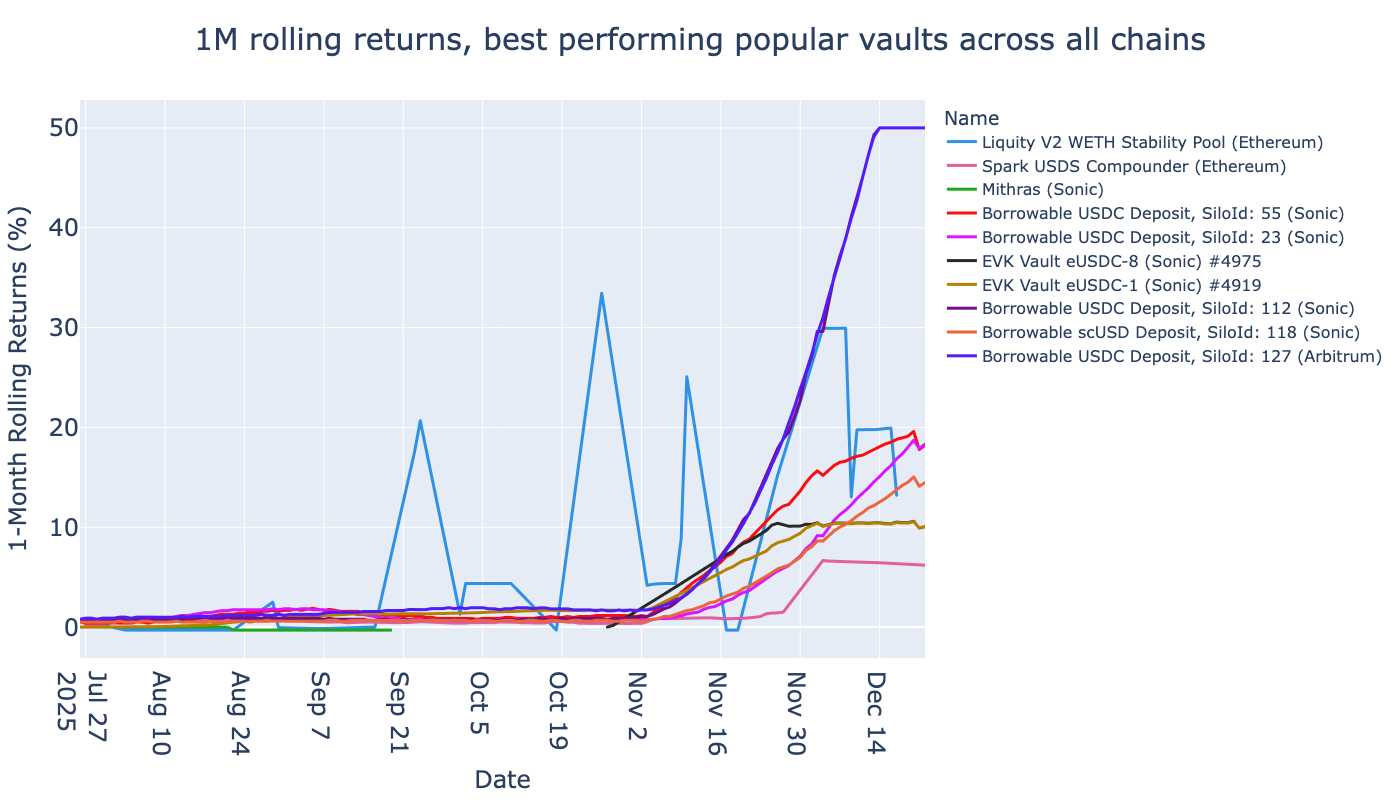

In [12]:
# display(lifetime_data_filtered_df.head(2))

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=lifetime_data_filtered_df,
    clip_up=50,  # Clip up to 700% returns
    clip_down=-0.30,
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best performing popular vaults across all chains",
)
fig.show()

### Best performing low volatile vaults

- Remove volatile vaults to focus on delta neutral vaults


Volatility min: 0.0000, max: 7801514708088.4336


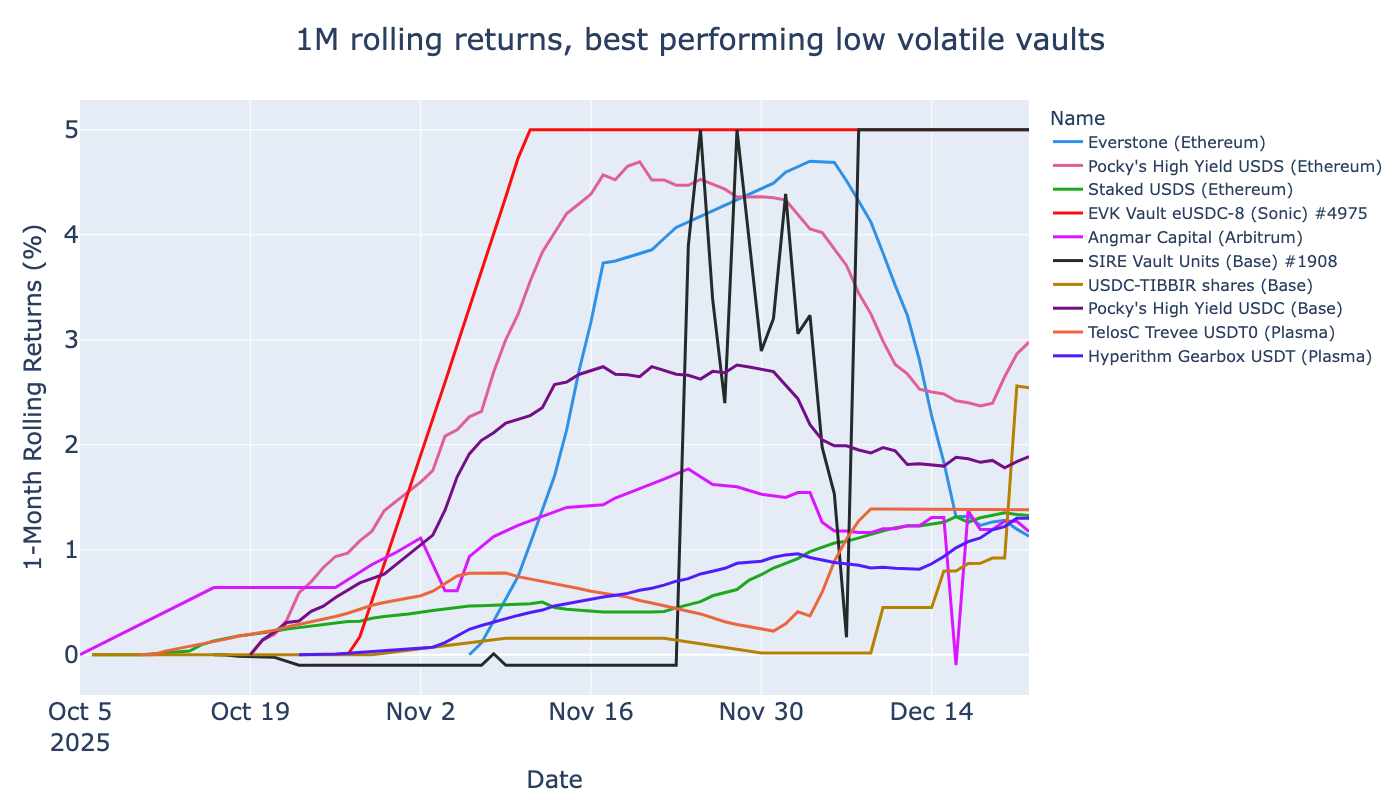

In [13]:
print(f"Volatility min: {lifetime_data_filtered_df['three_months_volatility'].min():.4f}, max: {lifetime_data_filtered_df['three_months_volatility'].max():.4f}")

non_volatile_df = lifetime_data_filtered_df[lifetime_data_filtered_df["three_months_volatility"] < 0.001]

# display(non_volatile_df)

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=non_volatile_df,
    clip_up=5,  # Clip up to 700% returns
    clip_down=-0.10,
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best performing low volatile vaults",
)
fig.show()

### Best performing vaults returns correlation

- How uncorrelated the returns of the top vaults are
- We use special filtering criteria to create the list of top vaults to compare



For the correlation matrix, we choose the top 20 vaults by their 3M returns, with minimum TVL of 50,000 USD and then limiting to 2 vaults per protocol to have more variety.


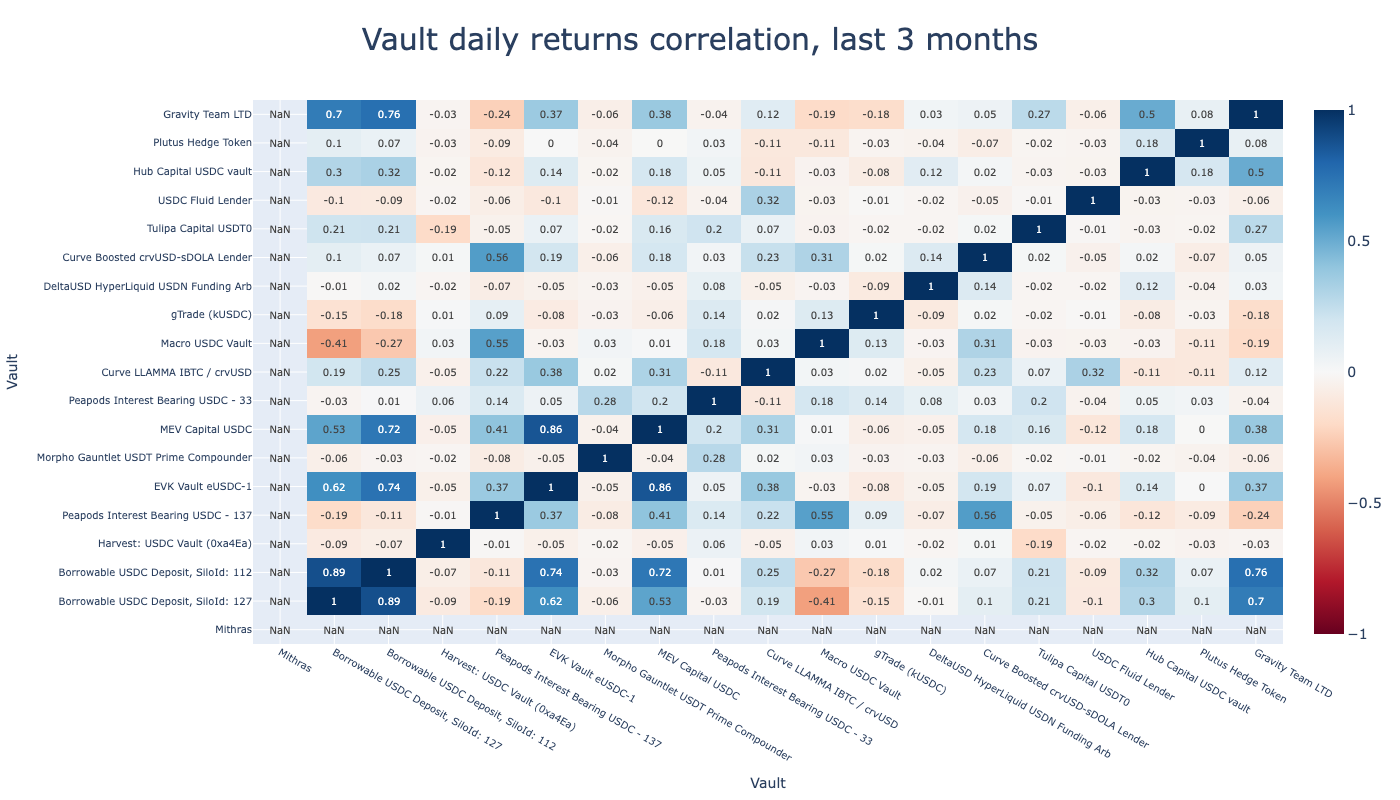

Selected vaults for correlation comparison:
|    | Vault                                                                                                                                                                                          | 3M return ann. (net / gross)   |   3M sharpe |   Age (years) | Chain                                                               | Protocol                      | Denomination   | TVL USD (current / peak)   |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|------------:|--------------:|:--------------------------------------------------------------------|:------------------------------|:---------------|:---------------------------|
|  1 | [https://tradingstrategy.ai/trading-view/sonic/vaults/mithras](https://tradingstrategy.ai/trading-view/sonic/vaults/mithras)   

In [14]:
from eth_defi.research.vault_correlation import choose_vaults_for_correlation_comparison, visualise_vault_returns_correlation

selected_lifetime_data_df = choose_vaults_for_correlation_comparison(
    lifetime_data_df,
    min_nav=50_000,
    per_protocol=2,
    max=20,
)


# display(returns_df.head())

last_ts = returns_df.index.max()
cut_off = last_ts - pd.Timedelta(days=90)
three_months_returns_df = returns_df.loc[returns_df.index > cut_off]

fig = visualise_vault_returns_correlation(
    selected_lifetime_data_df=selected_lifetime_data_df,
    returns_df=three_months_returns_df,
)
fig.update_xaxes(tickfont=dict(size=10), title_font=dict(size=14))
fig.update_yaxes(tickfont=dict(size=10), title_font=dict(size=14))
fig.update_coloraxes(colorbar=dict(tickfont=dict(size=10), title_font=dict(size=10)))

# Alternative: directly update the colorbar on the trace
fig.update_traces(
    colorbar=dict(
        tickfont=dict(size=14),
        title=dict(font=dict(size=14))
    )
)

fig.show()

# BLOG_POST_COLUMNS = [
#     "Vault", 
#     "1M return ann. (net / gross)", 
#     "3M return ann. (net / gross)", 
#     "Lifetime return ann. (net / gross)", 
#     "3M sharpe",     
#     "TVL USD (current / peak)", 
#     "Age (years)", 
#     "Denomination", 
#     "Chain", 
#     "Protocol",
# ]

human_df = format_lifetime_table(selected_lifetime_data_df)
markdown_df = format_markdown_table(
    human_df, 
    ["Vault", "3M return ann. (net / gross)", "3M sharpe", "Age (years)",  "Chain", "Protocol",  "Denomination", "TVL USD (current / peak)"],
)
print("Selected vaults for correlation comparison:")

print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

### Best performing vaults by a chain

- Take 5 top vaults from each 
- TVL filter applied

In [15]:
nav_threshold = 100_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]


# Get top 5 vaults by one_month_returns for each chain with ranking
def get_top_vaults_by_chain(df, metric_column="one_month_cagr", top_n=5):
    result_dfs = []

    df = df.reset_index()

    for chain in df["chain"].unique():
        chain_df = df[df["chain"] == chain].copy()

        # Sort by the metric in descending order
        chain_df = chain_df.sort_values(by=metric_column, ascending=False)

        # Take top N entries
        top_chain_df = chain_df.head(top_n).copy()

        result_dfs.append(top_chain_df)

    # Combine all chains
    combined_df = pd.concat(result_dfs, ignore_index=True)

    return combined_df


# Get top 5 vaults by one_month_cagr for each chain
top_vaults_by_chain_df = get_top_vaults_by_chain(lifetime_data_filtered_df, metric_column="one_month_cagr", top_n=5)

# BLOG_POST_COLUMNS = [
#     "Vault", 
#     "1M return ann. (net / gross)", 
#     "3M return ann. (net / gross)", 
#     "Lifetime return ann. (net / gross)", 
#     "3M sharpe",     
#     "TVL USD (current / peak)", 
#     "Age (years)", 
#     "Denomination", 
#     "Chain", 
#     "Protocol",
# ]

# For chain comparison, we order a bit differently
CHAIN_COMPARISON_COLUMNS = [
    "Chain",
    "Protocol",
    "Vault",
    "1M return ann. (net / gross)", 
    "3M return ann. (net / gross)",
    "Lifetime return ann. (net / gross)", 
    "TVL USD (current / peak)",
    "Age (years)",
    "Denomination",
]


top_vaults_by_chain_df = top_vaults_by_chain_df.sort_values(by=["chain", "one_month_cagr"], ascending=[True, False])
sorted_df = format_lifetime_table(top_vaults_by_chain_df, profit_presentation="net_only")
# display(top_vaults_by_chain_df)
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS, hide_index=False)

markdown_df = markdown_df[CHAIN_COMPARISON_COLUMNS]

print(markdown_df.to_markdown(index=False, tablefmt="pipe", floatfmt=",.2f"))

| Chain                                                                     | Protocol                      | Vault                                                                                                                                                                                                    | 1M return ann. (net / gross)   | 3M return ann. (net / gross)   | Lifetime return ann. (net / gross)   | TVL USD (current / peak)   |   Age (years) | Denomination   |
|:--------------------------------------------------------------------------|:------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|:-------------------------------|:-------------------------------------|:---------------------------|--------------:|:---------------|
| [Arbitrum](https://tradingstrategy.ai/

### Best-performing large vaults (min $2M TVL), list


In [16]:
nav_threshold = 2_000_000
event_threshold = 10

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

# print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
# print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
#   print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="one_month_cagr", ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

sorted_df = format_lifetime_table(lifetime_data_filtered_df.head(50), profit_presentation="net_only")
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|    | Vault                                                                                                                                                                                                      | 1M return ann. (net / gross)   | 3M return ann. (net / gross)   | Lifetime return ann. (net / gross)   |   3M sharpe | TVL USD (current / peak)   |   Age (years) | Denomination   | Chain                                                                 | Protocol                      |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|:-------------------------------|:-------------------------------------|------------:|:---------------------------|--------------:|:---------------|:----------------------------------------------------------------------|:------------------------------|
|  1 |

### Best-performing large vaults (min $2M TVL), chart 


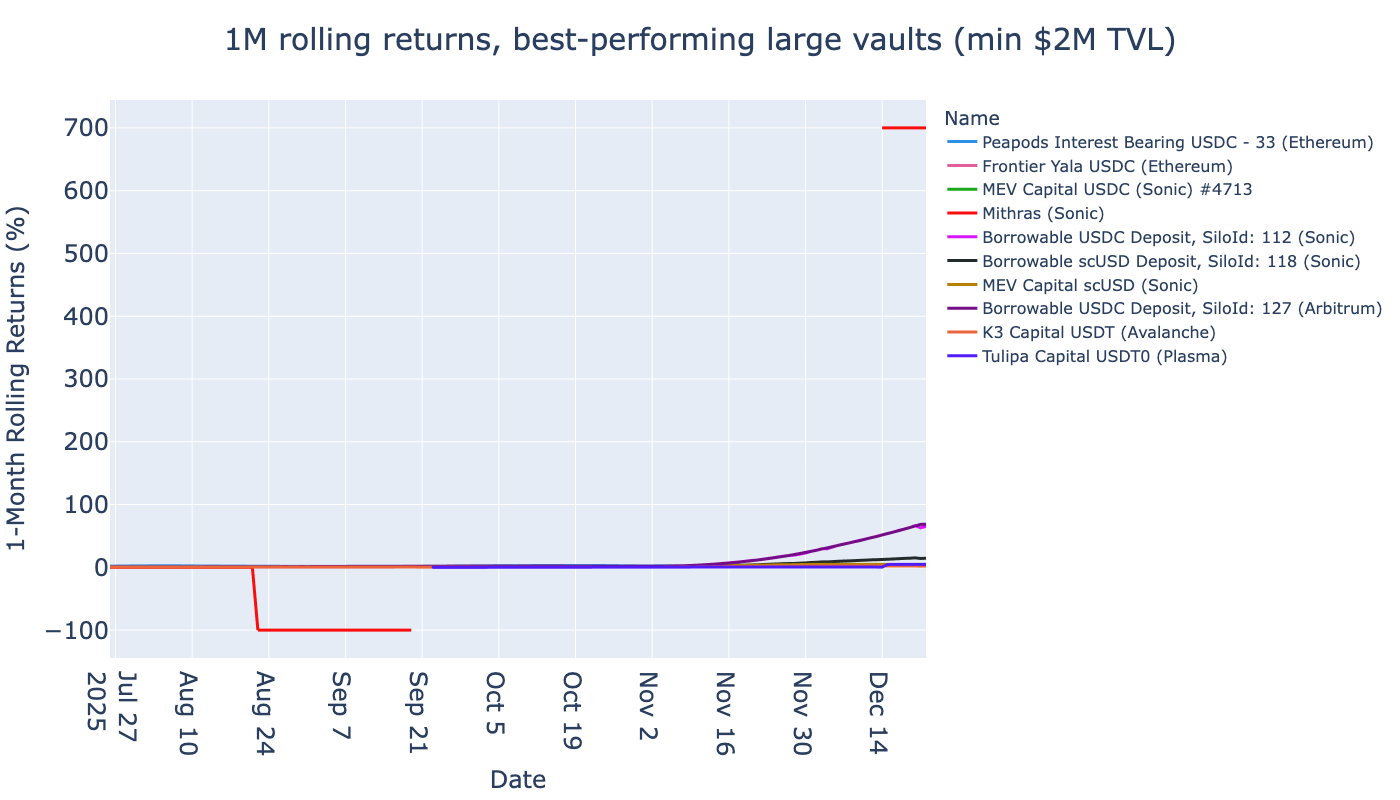

In [17]:
rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=lifetime_data_filtered_df,
    clip_up=700,  # Clip up to 700% returns
)

# display(rolling_returns_df.head(3))
# display(rolling_returns_df.tail(3))

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, best-performing large vaults (min $2M TVL)",
)
fig.show()

### Best-performing large vaults, non-volatile, chart

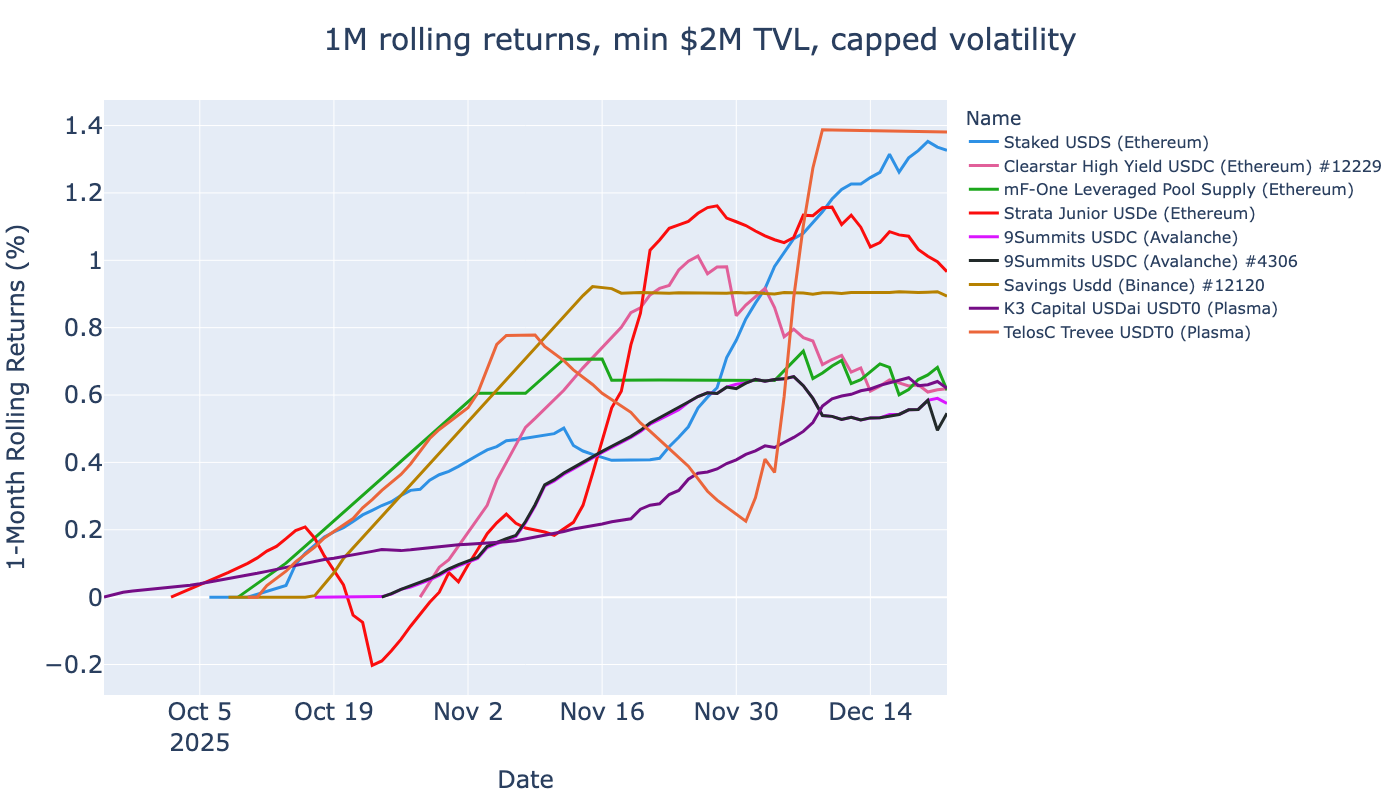

In [18]:
non_volatile_df = lifetime_data_filtered_df[lifetime_data_filtered_df["three_months_volatility"] < 0.001]

# display(non_volatile_df)

rolling_returns_df = calculate_rolling_returns(
    returns_df,
    filtered_vault_list_df=non_volatile_df,
    clip_up=700,  # Clip up to 700% returns
)

fig = visualise_rolling_returns(
    rolling_returns_df,
    title="1M rolling returns, min $2M TVL, capped volatility",
)
fig.show()

### Best performing new vaults

- Vaults less than two months old
- Have more than USD 15k in deposits
- Have more than 10 depositors

In [19]:
nav_threshold = 15_000
event_threshold = 10
age_threshold = 2 / 12  # Two months

lifetime_data_filtered_df = lifetime_data_df[(lifetime_data_df["current_nav"] >= nav_threshold) & (lifetime_data_df["event_count"] >= event_threshold) & (lifetime_data_df["years"] <= age_threshold)]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df["lifetime_return"] <= 0]

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by="one_month_cagr", ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

sorted_df = format_lifetime_table(lifetime_data_filtered_df.head(50), profit_presentation="net_only")
markdown_df = format_markdown_table(sorted_df, BLOG_POST_COLUMNS)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

|    | Vault                                                                                                                                                                                                    | 1M return ann. (net / gross)   | 3M return ann. (net / gross)   | Lifetime return ann. (net / gross)   |   3M sharpe | TVL USD (current / peak)   |   Age (years) | Denomination   | Chain                                                                 | Protocol                      |
|---:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------|:-------------------------------|:-------------------------------------|------------:|:---------------------------|--------------:|:---------------|:----------------------------------------------------------------------|:------------------------------|
|  1 | [ht

## All vaults

- Display all vaults included in this benchmark, sorted by TVL
- Min TVL 1k USD

In [20]:


# BLOG_POST_COLUMNS = [
#     "Vault", 
#     "1M return ann. (net / gross)", 
#     "3M return ann. (net / gross)", 
#     "Lifetime return ann. (net / gross)", 
#     "3M sharpe",     
#     "TVL USD (current / peak)", 
#     "Age (years)", 
#     "Denomination", 
#     "Chain", 
#     "Protocol",
# ]

display(lifetime_data_filtered_df.head(2))

# A vault needs at least 50 USD TVL to be considered on this list
lifetime_data_filtered_df = lifetime_data_df.sort_values("current_nav", ascending=False)
lifetime_data_filtered_df = lifetime_data_filtered_df[
    (lifetime_data_filtered_df["current_nav"] >= 10_000.0) &
    (lifetime_data_filtered_df["event_count"] >= 10) 
]

column_to_shift = ["Vault", "TVL USD (current / peak)",  "Age (years)", "Lifetime return ann. (net / gross)", "Deposit events"]
columns = column_to_shift + [c for c in BLOG_POST_COLUMNS if c not in column_to_shift]

sorted_df = format_lifetime_table(lifetime_data_filtered_df, profit_presentation="net_only")

print(f"Total {len(sorted_df):,} vaults with min TVL 10k USD")

markdown_df = format_markdown_table(sorted_df, columns)
print(markdown_df.to_markdown(index=True, tablefmt="pipe", floatfmt=",.2f"))

three_months_cagr                    name              vault_slug  \
2401               0.00       EVK Vault eUSDC-8     evk-vault-eusdc-8-2   
6415               0.00  Hyperithm Gearbox USDT  hyperithm-gearbox-usdt   

                    protocol_slug  lifetime_return  lifetime_return_net  cagr  \
2401                        euler             0.21                 0.21  2.41   
6415  protocol-not-yet-identified             0.02                  NaN  0.13   

      cagr_net  three_months_returns  three_months_returns_net  \
2401      2.41                  0.00                      0.00   
6415       NaN                  0.00                      0.00   

      three_months_cagr_net  three_months_sharpe  three_months_sharpe_net  \
2401                   0.00                 0.00                     0.00   
6415                   0.00                 0.00                     0.00   

      three_months_volatility  one_month_returns  one_month_returns_net  \
2401                     0.00               0.11                   0.11   
6415                     0.00               0.01                    NaN   

      one_month_cagr  one_month_cagr_net denomination normalised_denomination  \
2401            2.47                2.47         USDC                    USDC   
6415            0.18                 NaN        USDT0                    USDT   

     denomination_slug       share_token   chain     peak_nav  current_nav  \
2401              usdc           eUSDC-8   Sonic   178,561.98   178,561.98   
6415              usdt  hyperGearboxUSDT  Plasma 8,461,410.56   626,049.82   

      years  mgmt_fee  perf_fee  deposit_fee  withdraw_fee  \
2401   0.15      0.00      0.10         0.00          0.00   
6415   0.16       NaN       NaN          NaN           NaN   

                                fee_mode fee_internalised  \
2401  VaultFeeMode.internalised_skimming             True   
6415                                None             None   

                                             gross_fees  \
2401  FeeData(fee_mode=<VaultFeeMode.internalised_sk...   
6415  FeeData(fee_mode=None, management=None, perfor...   

                                               net_fees        fee_label  \
2401  FeeData(fee_mode=<VaultFeeMode.internalised_sk...  0% / 10% (int.)   
6415  FeeData(fee_mode=None, management=None, perfor...            ? / ?   

     lockup  event_count                       protocol  \
2401 0 days        34.00                          Euler   
6415    NaT       621.00  <protocol not yet identified>   

                               risk  risk_numeric  \
2401  VaultTechnicalRisk.negligible          1.00   
6415                           None           NaN   

                                                   id start_date   end_date  \
2401   146-0x683dbc88b371ae48962b56e36e5a0c34e3ad4caf 2025-10-27 2025-12-22   
6415  9745-0xb74760fd26400030620027dd29d19d74d514700e 2025-10-23 2025-12-22   

                                         address  chain_id  stablecoinish  \
2401  0x683dbc88b371ae48962b56e36e5a0c34e3ad4caf       146           True   
6415  0xb74760fd26400030620027dd29d19d74d514700e      9745           True   

     first_updated_at  first_updated_block last_updated_at  \
2401       2025-10-27        52,122,332.00      2025-12-22   
6415       2025-10-23         4,283,245.00      2025-12-22   

      last_updated_block  last_share_price      features flags notes  \
2401       58,573,532.00              1.21  [euler_like]    {}  None   
6415        9,478,045.00              1.02            []    {}  None   

                                                   link  \
2401  https://app.euler.finance/earn/0x683dbC88B371A...   
6415  https://routescan.io/address/0xB74760FD2640003...   

                                  trading_strategy_link one_month_start  \
2401  https://tradingstrategy.ai/trading-view/sonic/...      2025-11-21   
6415  https://tradingstrategy.ai/trading-view/plasma...             NaT   

     o

Total 1,228 vaults with min TVL 10k USD
|      | Vault                                                                                                                                                                                                                                                | TVL USD (current / peak)      |   Age (years) | Lifetime return ann. (net / gross)   | Deposit events   | 1M return ann. (net / gross)   | 3M return ann. (net / gross)   |   3M sharpe | Denomination   | Chain                                                                     | Protocol                      |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------|--------------:|:-------------------------------------|:-----------------|:-------------------------------